# Polynomial Regression

## Define a custom sklearn predictor

*   Read more about mixin by sklearn [here](#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.base)
*   Show the source code for linear regression: [Linear Regression Docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)



In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

class PolynomialRidgeRegressor(BaseEstimator, RegressorMixin):
  def __init__(self, degree=10, alpha=1.0):
    self.degree = degree
    self.alpha = alpha

  def fit(self, X, y):
    self.model = make_pipeline(PolynomialFeatures(degree=self.degree),
                               Ridge(alpha=self.alpha))
    self.model.fit(X, y)
    self._is_fitted = True
    return self

  def predict(self, X):
    # self.check_if_fitted()
    return self.model.predict(X)

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class ConstantRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, c=None):
        self.c = c

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        if self.c is None:
            self.const_ = y.mean()
        else:
            self.const_ = self.c
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        return np.array(X.shape[0]*[self.const_])

## Synthesize Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Generate data
x0, x1 = -0.25, 1.5
x = np.linspace(x0, x1, 100)
coefficients = [4, -7, 2, -4]  # coefficients for a quadratic polynomial: 4x^3 -7*x^2 - 2x -4

# Calculate y values
global y_population
y_population = np.polyval(coefficients, x)

In [5]:
np.random.seed(123456789)
n_gt = 40

# Generate random points from the polynomial function with noise
x_gt_1d = np.random.uniform(low=x0, high=x1, size=n_gt)
y_gt = np.random.normal(0, 0.4, n_gt) + np.polyval(coefficients, x_gt_1d)

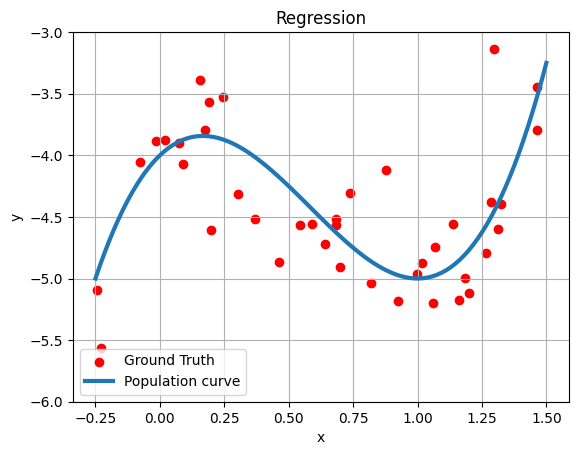

In [6]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the polynomial
ax.set(xlabel='x', ylabel='y', title='Regression')
ax.scatter(x_gt_1d, y_gt, label='Ground Truth', c='r')
ax.plot(x, y_population, label='Population curve', lw=3)
ax.set_ylim([-6, -3])

ax.legend()
ax.grid(True)

# Show the plot
plt.show()

## Create Train and Test data sets

In [7]:
from sklearn.model_selection import train_test_split

Converting x which is an 1d vector to a 2d array. Sklearn assumes that the feature array is 2d. Documentation too uses 'X' and not 'x'.

In [8]:
x_gt = x_gt_1d[:, np.newaxis]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_gt, y_gt, train_size = 0.7, random_state=42)

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28, 1), (12, 1), (28,), (12,))

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
parameters = {'degree': list(range(1,15)), 'alpha': np.logspace(-9, 2, 12)}

In [13]:
from sklearn.metrics import make_scorer, mean_squared_error
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error, greater_is_better=False)

In [14]:
# parameters = {'c':[None, 0,1,2,3,4,5,6]}
# gs = GridSearchCV(ConstantRegressor(), parameters, cv=3, return_train_score=True)

In [15]:
gs = GridSearchCV(PolynomialRidgeRegressor(), parameters, cv=3, scoring=mse, return_train_score=True)

In [16]:
gs.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=PolynomialRidgeRegressor(),
             param_grid={'alpha': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                    14]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [17]:
import pandas as pd

In [18]:
df = pd.DataFrame(gs.cv_results_)

In [19]:
optimal_params = df[df['rank_test_score'] == 1]['params'].values[0]
optimal_params

{'alpha': 1e-08, 'degree': 9}

In [20]:
prl1 = PolynomialRidgeRegressor(**optimal_params)
prl1.fit(x_train, y_train)
yfit = prl1.predict(x[:, np.newaxis])

train_rmse = mean_squared_error(prl1.predict(x_train), y_train, squared=False)
test_rmse = mean_squared_error(prl1.predict(x_test), y_test, squared=False)

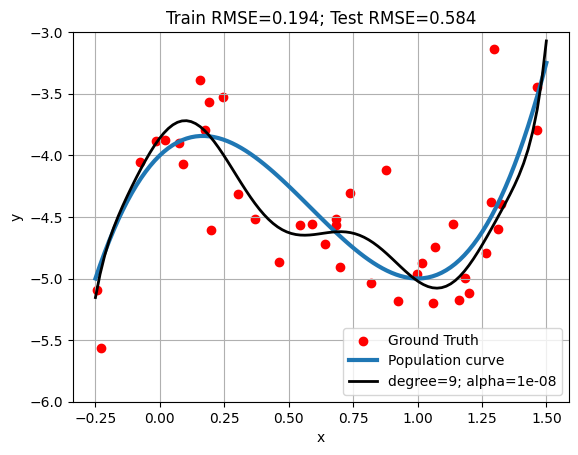

In [21]:
# %%script echo skipping
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the polynomial
ax.set(xlabel='x', ylabel='y', title=f'Train RMSE={train_rmse:.3f}; Test RMSE={test_rmse:.3f}')
ax.scatter(x_gt, y_gt, label='Ground Truth', c='r')
ax.plot(x, y_population, label='Population curve', lw=3)
ax.plot(x, yfit, label=f"degree={optimal_params['degree']}; alpha={optimal_params['alpha']}", lw=2, c='black')

ax.set_ylim([-6, -3])
ax.legend()
ax.grid(True)

# Show the plot
plt.show()